In [87]:
import tailgating as tg
import pennylane as qml
import pennylane.numpy as np
from pennylane import qchem
import scipy
from tqdm.notebook import tqdm
import chemistry as chem
import autohf as hf
import copy
import itertools
import generative_qq as qq
from matplotlib import pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyscf/lib/misc.py:46: H5pyDeprecationWarning: Using default_file_mode other than 'r' is deprecated. Pass the mode to h5py.File() instead.
  h5py.get_config().default_file_mode = 'a'


In [88]:
# Basic information
symbols = ["H", "H", "H"]
geometry = np.array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -9.13622790e-01, -1.58251261e+00,
        0.00000000e+00, -1.82729998e+00, -5.31182316e-05,  0.00000000e+00])

# Specifies the electrons and orbitals
electrons, active_electrons = 2, 2
orbitals, active_orbitals = 3, 3
wires = list(range(2 * active_orbitals))

# Defines the molecule and the active space
core, active = qchem.active_space(electrons, orbitals, active_electrons=active_electrons, active_orbitals=active_orbitals)

class H3_Plus:
    basis_name = "sto-3g"
    symbols = symbols
    active_electrons = active_electrons
    active_orbitals = active_orbitals
    charge = 0
    multiplicity = 1
    
    geometry = geometry

In [89]:
mol = H3_Plus() # Molecule

In [90]:
# Generates the gate pool to use for ADAPT-VQE
gate_pool = tg.batch_gate_pool(mol)

# Generates the sparse molecular Hamiltonian (used in the VQE simulations)
H = hf.sparse_H(mol, wires)(mol.geometry)

# Other information: the device, Hartree-Fock state, optimizer, and numbers of optimization steps
dev = qml.device('default.qubit', wires=wires)
hf_state = qchem.hf_state(active_electrons, 2 * active_orbitals)
optimizer = qml.GradientDescentOptimizer(stepsize=0.3)
vqe_steps = 100

# Performs the original ADAPT-VQE procedure
original_seq, original_params = tg.batch_adapt_vqe(H, dev, gate_pool, hf_state, optimizer, vqe_steps, bar=True, sparse=True)

/Users/jackceroni/Library/Python/3.9/lib/python/site-packages/PennyLane-0.21.0.dev0-py3.9.egg/pennylane/_grad.py:93: UserWarning: Starting with PennyLane v0.21.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

In [91]:
original_seq

[<function tailgating.vqe.batch_gate_pool.<locals>.<lambda>(p, w=[0, 1, 2, 3])>,
 <function tailgating.vqe.batch_gate_pool.<locals>.<lambda>(p, w=[0, 1, 4, 5])>]

In [92]:
# Circuit yielded from ADAPT-VQE
def circuit(params):
    qml.BasisState(hf_state, wires=wires)
    for p, gate in zip(params, original_seq):
        gate(p)

In [93]:
# Generates first and second derivatives of the Hamiltonian
H1 = hf.generate_d_hamiltonian(mol, wires, bar=True)(geometry.flatten())

  0%|          | 0/9 [00:00<?, ?it/s]

/Users/jackceroni/Library/Python/3.9/lib/python/site-packages/autohf-0.0.1-py3.9.egg/autohf/hartreefock.py:209: RuntimeWarning: divide by zero encountered in true_divide


In [94]:
# Hamiltonian second derivative

H2 = hf.generate_dd_hamiltonian(mol, wires, bar=True)(geometry.flatten())

  0%|          | 0/9 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in true_divide
  return f_raw(*args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/autograd/numpy/numpy_jvps.py:46: RuntimeWarning: invalid value encountered in true_divide
  lambda g, ans, x, y : - g * x / y**2)


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [95]:
flat_gate_pool = gate_pool[0]
flat_gate_pool.extend(gate_pool[1])

# Performs the tailgating procedure
hamiltonians = [H1[0], H1[1], H1[3], H1[4], H1[6], H1[7]]

# A method for tailgating a circuit
def tailgate(dH, dev, circuit, operator_pool, params, tol=1e-6):
    """Performs the tail-gating procedure"""
    gates = []
    bar = tqdm(operator_pool)
    n = []

    for op in bar:
        @qml.qnode(dev)
        def cost_fn(param):
            circuit(params)
            op(param)
            return qml.expval(dH)
        gr = qml.grad(cost_fn)(0.0)
        if abs(gr) > tol:
            gates.append(op)
        else:
            n.append(op)
    return n, gates

# Gates added to the circuit through tailgating
added_gates = []
for dh in hamiltonians:
    flat_gate_pool, gates = tailgate(dh, dev, circuit, flat_gate_pool, original_params)
    added_gates.extend(gates)

added_gates = set(added_gates)

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [96]:
# Creates the new gate pool
new_seq = original_seq + list(added_gates)
new_params = original_params + [0.0 for _ in range(len(added_gates))]

# Circuit yielded from tailgating
def new_circuit(params):
    qml.BasisState(hf_state, wires=wires)
    for p, gate in zip(params, new_seq):
        gate(p)

In [97]:
new_params

[0.18818972942951995,
 0.18902529166265483,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [98]:
e = []
e_e = []

for r in range(-14, 14):
    H_r = hf.sparse_H(mol, wires)(mol.geometry + 0.05 * r * np.array([0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 1.0, 0.0]))
    H_r_mat = H_r.matrix.toarray()
    e_e.append(qq.allowed_vec_val(H_r_mat, 2))
    
    energy, params = tg.vqe(new_circuit, H_r, dev, optimizer, 500, new_params, sparse=True)
    e.append(params)

  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [16]:
@qml.qnode(dev)
def state_circuit(params):
    qml.BasisState(hf_state, wires=wires)
    for p, gate in zip(params, new_seq):
        gate(p)
    return qml.state()

exact_e = [e_e[j][0].T[0] for j in range(len(e_e))]
e_r = [state_circuit(p) for p in e]
overlaps = [np.inner(np.conj(j), k) * np.inner(np.conj(k), j) for j, k in zip(exact_e, e_r)]

In [ ]:
fig = plt.figure(figsize=(20,14))
ax = plt.axes()

plt.scatter([x * 0.05 for x in range(-14, 14)], overlaps)
plt.plot([x * 0.05 for x in range(-14, 14)], overlaps, label="Non-tailgated")

#plt.plot([0.0 for _ in range(10)], np.linspace(0.999, 1.0, 10))

plt.ylabel("Fidelity", fontsize=18)
plt.xlabel("Atomic Displacement (Bohr)", fontsize=18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, prop={'size':18})

In [14]:
print(overlaps)

[(0.999852125656292+0j), (0.9998486743193259+0j), (0.9998498284545346+0j), (0.9998553895516307-0j), (0.9998646050771961+0j), (0.9998769684197097+0j), (0.9998917141938128+0j), (0.999908254926671-0j), (0.9999256721290745-0j), (0.9999432120375846-0j), (0.9999600995608571-0j), (0.9999754135367308+0j), (0.99998809615349-0j), (0.9999967076015189-0j), (0.999999997705332-0j), (0.9999961448914587-0j), (0.9999829478690666-0j), (0.99995841991483+0j), (0.999919708045271+0j), (0.9998641365616084-0j), (0.9997886652584511-0j), (0.9996900022047951+0j), (0.9995651399904436+0j), (0.999410669743317-0j), (0.9992231123578571-0j), (0.9989988535781009-0j), (0.9987347062785231+0j), (0.9984268506794645-0j)]


In [17]:
print(overlaps)

[(0.9999999565931879+0j), (0.9999999668209432+0j), (0.9999999602048244+0j), (1.0000000490355483-0j), (1.000000017212312+0j), (1.0000000109289386+0j), (0.9999999654222352+0j), (1.000000024418253-0j), (1.0000000192322047-0j), (0.9999999780425238-0j), (0.9999999635800082-0j), (0.9999999858682624+0j), (1.0000000524857795-0j), (0.9999999778562895-0j), (0.9999999977172327-0j), (1.0000000438872099-0j), (0.9999999454340777-0j), (1.000000025920705+0j), (1.000000011218427+0j), (1.0000000369601918-0j), (1.0000000555100883-0j), (0.9999999395267711+0j), (0.9999999439494439+0j), (1.0000000094465817-0j), (1.0000000516073315-0j), (0.9999999466003644-0j), (1.0000000279580263+0j), (1.0000000005575287-0j)]


In [100]:
tailgated = [(0.9999999565931879+0j), (0.9999999668209432+0j), (0.9999999602048244+0j), (1.0000000490355483-0j), (1.000000017212312+0j), (1.0000000109289386+0j), (0.9999999654222352+0j), (1.000000024418253-0j), (1.0000000192322047-0j), (0.9999999780425238-0j), (0.9999999635800082-0j), (0.9999999858682624+0j), (1.0000000524857795-0j), (0.9999999778562895-0j), (0.9999999977172327-0j), (1.0000000438872099-0j), (0.9999999454340777-0j), (1.000000025920705+0j), (1.000000011218427+0j), (1.0000000369601918-0j), (1.0000000555100883-0j), (0.9999999395267711+0j), (0.9999999439494439+0j), (1.0000000094465817-0j), (1.0000000516073315-0j), (0.9999999466003644-0j), (1.0000000279580263+0j), (1.0000000005575287-0j)]

non = [(0.999852125656292+0j), (0.9998486743193259+0j), (0.9998498284545346+0j), (0.9998553895516307-0j), (0.9998646050771961+0j), (0.9998769684197097+0j), (0.9998917141938128+0j), (0.999908254926671-0j), (0.9999256721290745-0j), (0.9999432120375846-0j), (0.9999600995608571-0j), (0.9999754135367308+0j), (0.99998809615349-0j), (0.9999967076015189-0j), (0.999999997705332-0j), (0.9999961448914587-0j), (0.9999829478690666-0j), (0.99995841991483+0j), (0.999919708045271+0j), (0.9998641365616084-0j), (0.9997886652584511-0j), (0.9996900022047951+0j), (0.9995651399904436+0j), (0.999410669743317-0j), (0.9992231123578571-0j), (0.9989988535781009-0j), (0.9987347062785231+0j), (0.9984268506794645-0j)]

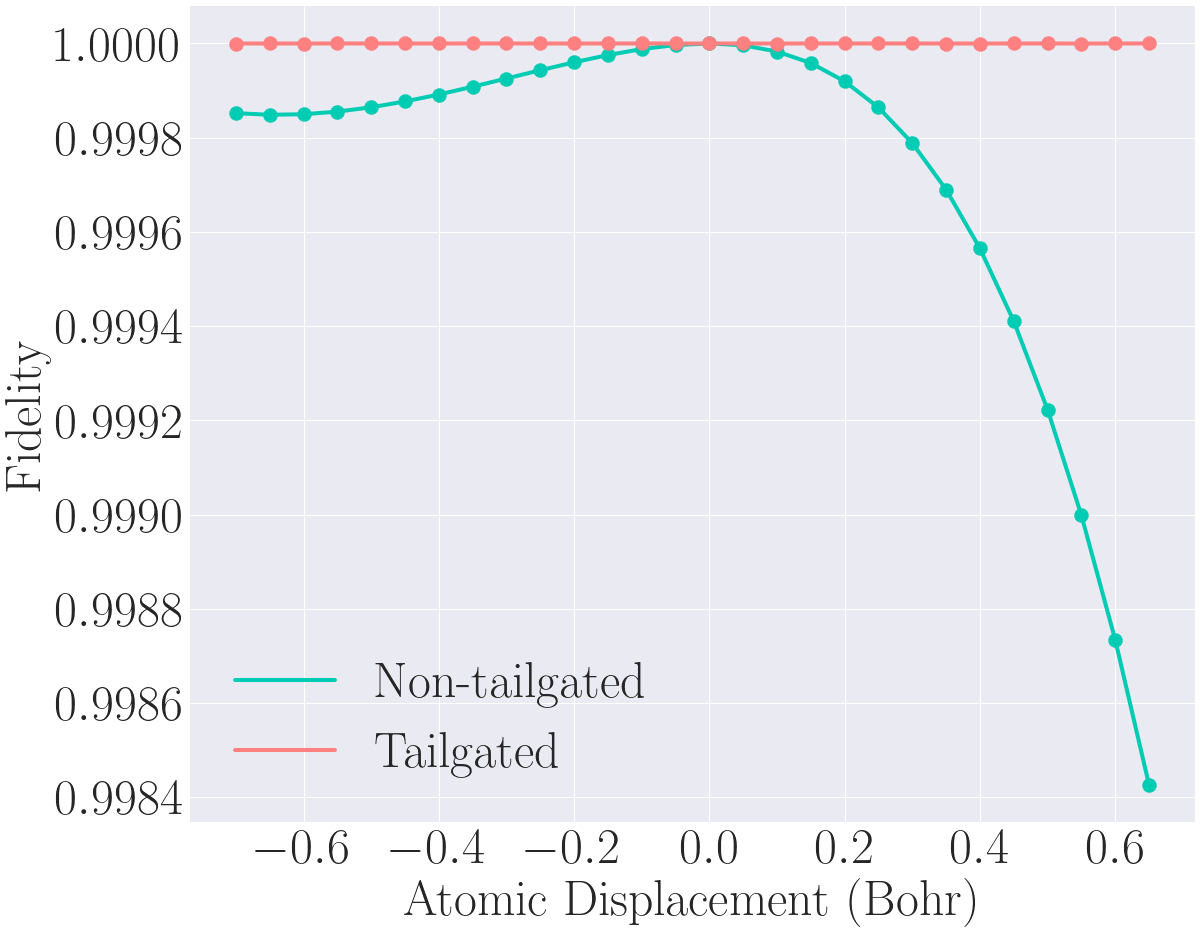

In [115]:
plt.style.use('seaborn')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
})
fig = plt.figure(figsize=(18, 15))
ax = plt.axes()

plt.scatter([x * 0.05 for x in range(-14, 14)],non,s=200, color="#00ccb3ff")
plt.plot([x * 0.05 for x in range(-14, 14)], non, label="Non-tailgated", linewidth=4, color="#00ccb3ff")
plt.scatter([x * 0.05 for x in range(-14, 14)], tailgated,s=200,color="#ff8080ff", zorder=10)
plt.plot([x * 0.05 for x in range(-14, 14)], tailgated, label="Tailgated", linewidth=4, color="#ff8080ff")

#plt.plot([0.0 for _ in range(10)], np.linspace(0.999, 1.0, 10))

plt.ylabel("Fidelity", fontsize=f)
plt.xlabel("Atomic Displacement (Bohr)", fontsize=f)

plt.xticks(fontsize=f)
plt.yticks(fontsize=f)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, prop={'size':f})
plt.show()

In [196]:
[x * 0.05 for x in range(-12, 9)].index(0)

12

In [198]:
overlaps[13]

(0.9999965538569509+0j)

In [1]:
from matplotlib import pyplot as plt

In [43]:
be_ov = [(0.999817589701284-0j), (0.9998190101632097-0j), (0.9998178141017939+0j), (0.999813858982601+0j), (0.9998069443697815-0j), (0.9997970758858481-0j), 
 (0.9997840706662979+0j), (0.9997672888802172-0j), (0.9997465109950081+0j), (0.999720959104477-0j), (0.9996900952072055+0j), (0.9996528203410175+0j), 
 (0.9996080600093945+0j), (0.9995545143908775-0j), (0.9994904937242429+0j), (0.9994136930292913-0j), (0.9993218726235014-0j), (0.9992116447534107-0j), 
 (0.9990793552801204+0j), (0.9989204355751418+0j), (0.9987293911884912-0j)]

be_ov_d = [(be_ov[i + 1] - be_ov[i - 1]) / 0.15 for i in range(1, len(be_ov) - 1)]

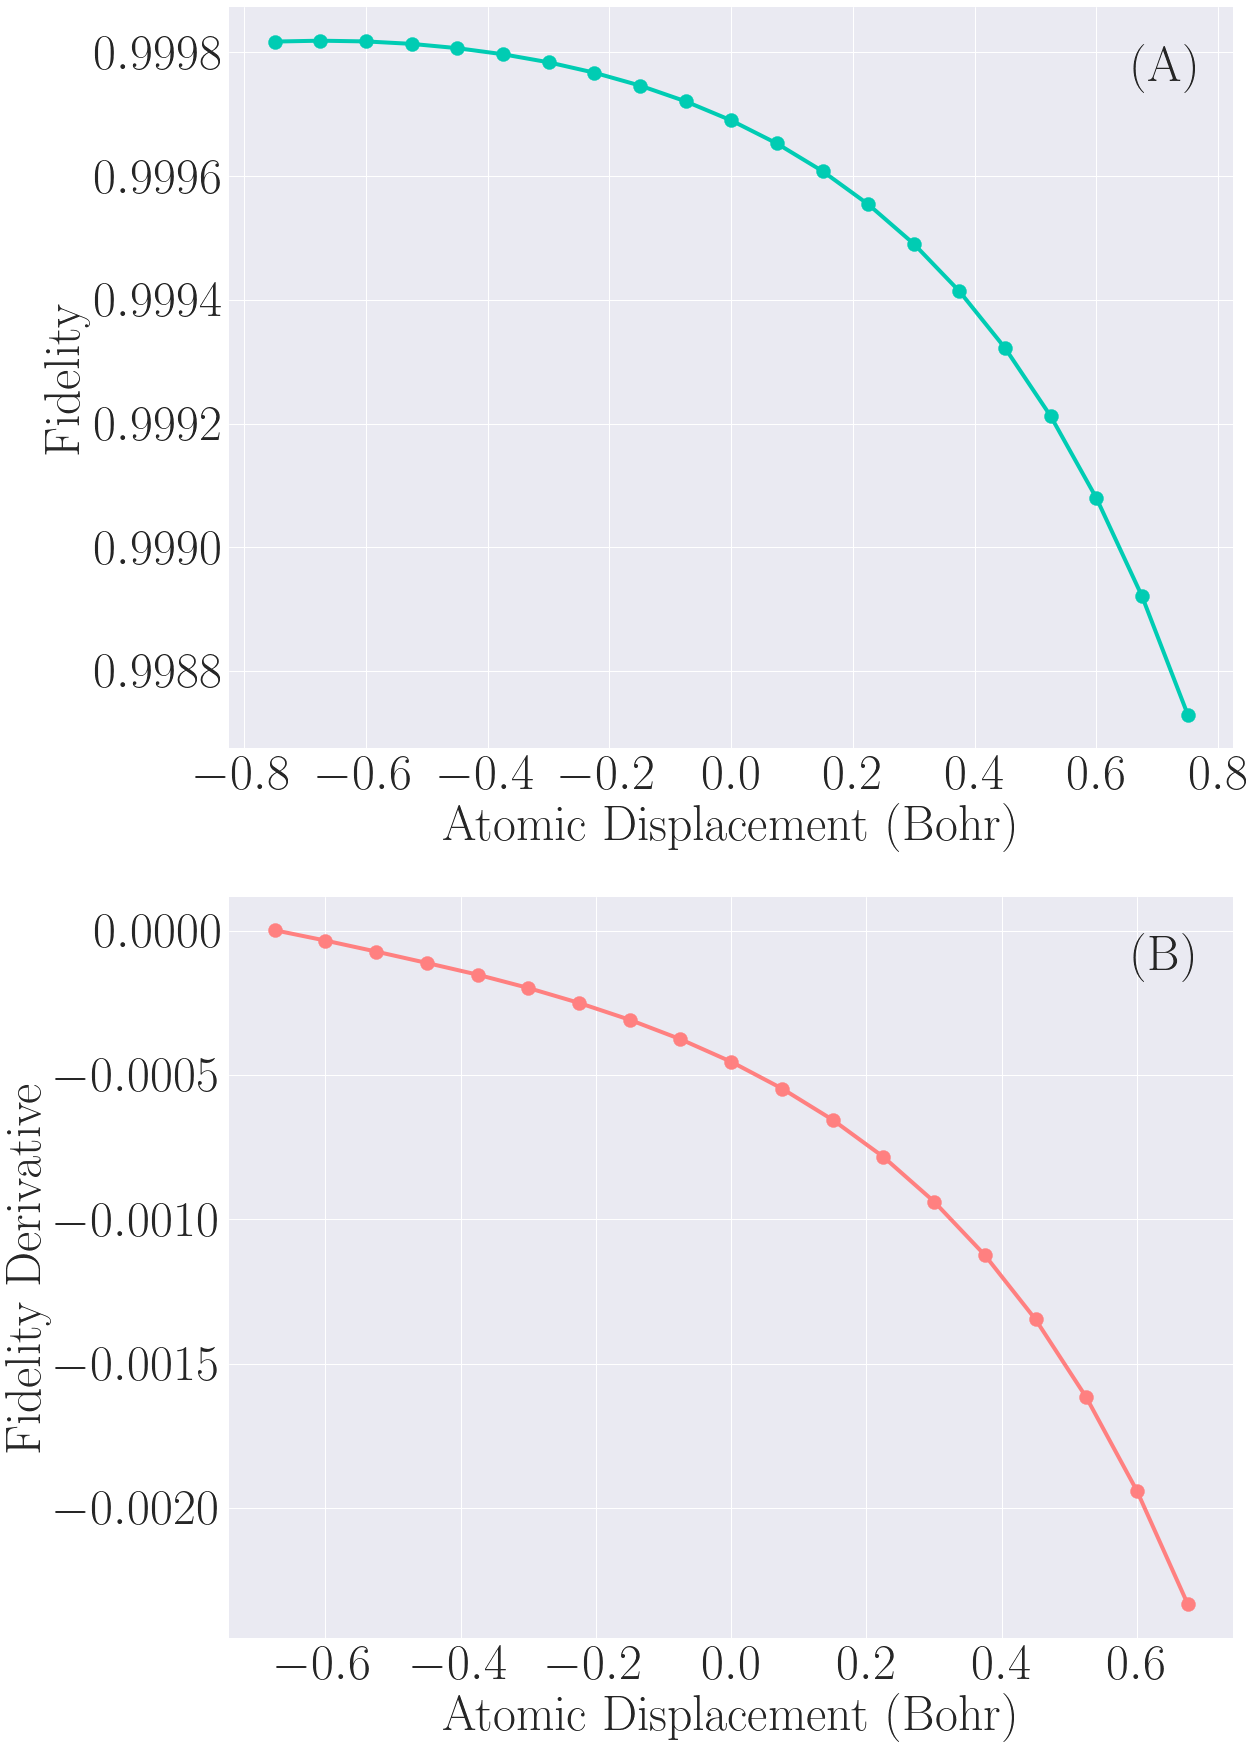

In [125]:
plt.style.use('seaborn')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
})

#plt.rcParams["font.weight"] = "ultrabold"
#plt.rcParams["axes.labelweight"] = "ultrabold"
#fig = plt.figure(figsize=(15,11))

fig, ax = plt.subplots(figsize=(18, 30))

ax1 = plt.subplot(2, 1, 1)
f = 50

ax1.annotate("(A)", xy=(0.9, 0.9), xycoords="axes fraction", fontsize=f)

ax1.scatter([x * 0.075 for x in range(-10, 11)], be_ov, color="#00ccb3ff", s=200)
ax1.plot([x * 0.075 for x in range(-10, 11)], be_ov, color="#00ccb3ff", linewidth=4)
plt.xticks(fontsize=f, fontweight="bold")
plt.yticks(fontsize=f)
plt.ylabel("Fidelity", fontsize=f)
plt.xlabel("Atomic Displacement (Bohr)", fontsize=f, fontweight="bold")

ax2 = plt.subplot(2, 1, 2)

ax2.annotate("(B)", xy=(0.9, 0.9), xycoords="axes fraction", fontsize=f)

ax2.scatter([x * 0.075 for x in range(-9, 10)], be_ov_d, color="#ff8080ff", s=200)
ax2.plot([x * 0.075 for x in range(-9, 10)], be_ov_d, color="#ff8080ff", linewidth=4)
plt.xticks(fontsize=f)
plt.yticks(fontsize=f)
plt.ylabel("Fidelity Derivative", fontsize=f)
plt.xlabel("Atomic Displacement (Bohr)", fontsize=f)


plt.show()